In [21]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from statsmodels.tsa.stattools import adfuller

In [32]:
# Create a list of US stocks 
stock_symbols = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'BRK-A', 'NVDA',
    'JPM', 'JNJ', 'V', 'PG', 'UNH', 'MA', 'DIS', 'HD', 'BAC', 'VZ',
    'INTC', 'KO', 'PFE', 'WMT', 'MRK', 'PEP', 'T', 'BA', 'XOM', 'ABBV',
    'NKE', 'MCD', 'CSCO', 'DOW', 'ADBE', 'IBM', 'CVX', 'CRM', 'ABT', 'MDT',
    'PYPL', 'NEE', 'COST', 'AMGN', 'CMCSA', 'NFLX', 'ORCL', 'PM', 'HON', 'ACN',
    'TMO', 'AVGO'
]

# Fetch the data from Yahoo Finance
df = {}
for symbol in stock_symbols:
    data = yf.download(symbol, start='2015-01-01', end='2023-01-01')
    df[symbol] = data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [33]:
print(df['AAPL'].Close)

Ticker            AAPL
Date                  
2015-01-02   24.347176
2015-01-05   23.661278
2015-01-06   23.663504
2015-01-07   23.995317
2015-01-08   24.917267
...                ...
2022-12-23  130.487793
2022-12-27  128.676834
2022-12-28  124.728371
2022-12-29  128.261230
2022-12-30  128.577866

[2014 rows x 1 columns]


In [34]:
stationary_stocks = []
p_values = []  

for symbol, data in df.items():
    result = adfuller(data['Close'])
    # A p-value less than 0.05 indicates that the data is stationary
    p_value = result[1]
    if p_value <= 0.05:
        stationary_stocks.append(symbol)
        p_values.append(p_value)

print("Stocks suitable for mean reversion strategy:")
for stock, p_value in zip(stationary_stocks, p_values):  # Use zip to iterate over both lists simultaneously
    print(f"Stock: {stock}, p-value: {p_value:.4f}")

Stocks suitable for mean reversion strategy:
Stock: T, p-value: 0.0331
Stock: IBM, p-value: 0.0211


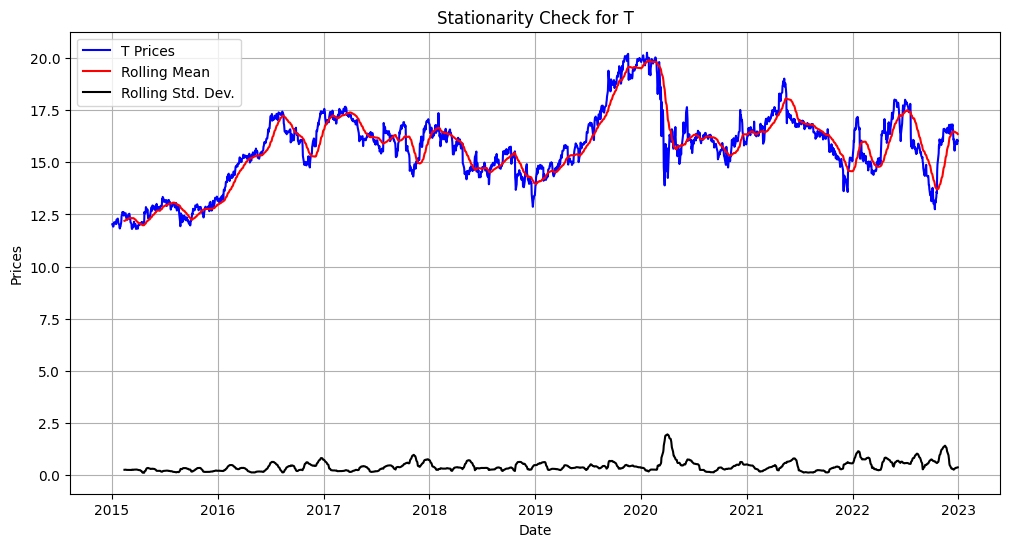

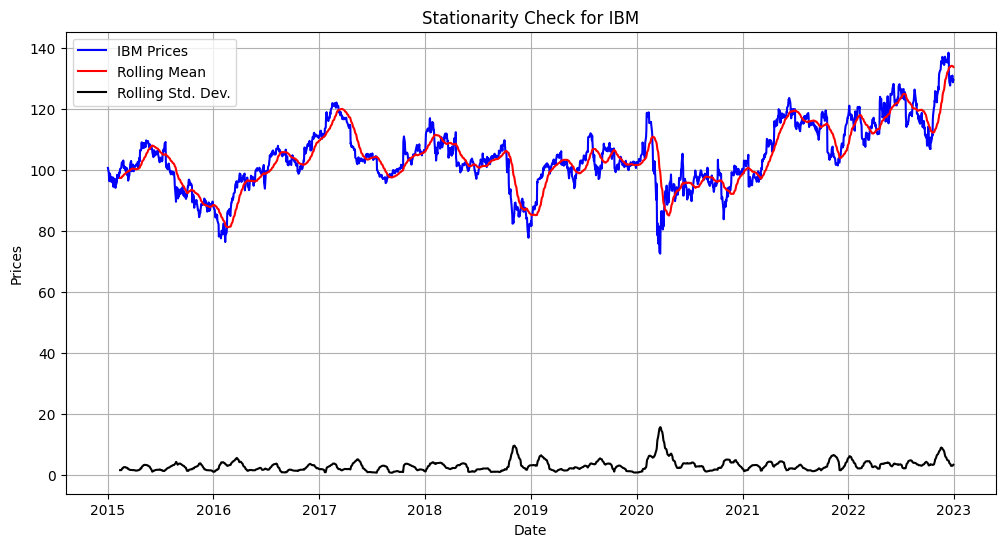

In [35]:
def plot_stationary_stocks(df, stationary_stocks):
    for stock in stationary_stocks:
        data = df[stock].Close
        
        # Calculate rolling statistics
        rolling_mean = data.rolling(window=30).mean()  # 30-day rolling mean
        rolling_std = data.rolling(window=30).std()   # 30-day rolling standard deviation
        
        # Plot the statistics
        plt.figure(figsize=(12, 6))
        plt.plot(data, label=f'{stock} Prices', color='blue')
        plt.plot(rolling_mean, label='Rolling Mean', color='red')
        plt.plot(rolling_std, label='Rolling Std. Dev.', color='black')
        plt.title(f'Stationarity Check for {stock}')
        plt.xlabel('Date')
        plt.ylabel('Prices')
        plt.legend()
        plt.grid(True)
        plt.show()


# Calling the function
plot_stationary_stocks(df, stationary_stocks)

In [36]:
class MeanReversion(Strategy):
    n1 = 30  # Period for the moving average
    
    def init(self):
        # Compute moving average
        self.offset = 0.01  # Buy/sell when price is 1% below/above the moving average
        prices = self.data['Close']
        self.ma = self.I(self.compute_rolling_mean, prices, self.n1)

    def compute_rolling_mean(self, prices, window):
        return [(sum(prices[max(0, i - window):i]) / min(i, window)) if i > 0 else np.nan for i in range(len(prices))]

    def next(self):
        size = 0.1
        # If price drops to more than offset% below n1-day moving average, buy
        if self.data['Close'] < self.ma[-1] * (1 - self.offset):
            if self.position.size < 0:  # Check for existing short position
                self.buy()  # Close short position
            self.buy(size=size)

        # If price rises to more than offset% above n1-day moving average, sell
        elif self.data['Close'] > self.ma[-1] * (1 + self.offset):
            if self.position.size > 0:  # Check for existing long position
                self.sell()  # Close long position
            self.sell(size=size)

In [52]:
stock_to_backtest = stationary_stocks[0]
df1 = df[stock_to_backtest]
# Simplify the column names
#df1.columns = df1.columns.droplevel(1)  # Drop the second level ('IBM') has ticker should to remove
df1
print(df1.head())

# Ensure columns are properly named for Backtest
if not set(['Open', 'High', 'Low', 'Close', 'Volume']).issubset(df1.columns):
    raise ValueError("The DataFrame must contain 'Open', 'High', 'Low', 'Close', and optionally 'Volume' columns.")

# Run the backtest
bt = Backtest(df1, MeanReversion, cash=100000, commission=.002)
stats = bt.run()
bt.plot()





Price           Close       High        Low       Open    Volume
Date                                                            
2015-01-02  12.027412  12.062923  11.927983  11.927983  27226736
2015-01-05  11.913773  12.045162  11.903120  12.027407  40288128
2015-01-06  11.931532  12.006104  11.842756  11.991900  39184839
2015-01-07  12.001100  12.153058  11.841906  12.149440  41917840
2015-01-08  12.120495  12.149439  11.993863  12.026425  30186935


GridPlot(id='p1686', ...)

In [53]:
print(stats)

Start                     2015-01-02 00:00:00
End                       2022-12-30 00:00:00
Duration                   2919 days 00:00:00
Exposure Time [%]                    99.75174
Equity Final [$]                 176810.99964
Equity Peak [$]                  179420.67516
Return [%]                             76.811
Buy & Hold Return [%]                33.37482
Return (Ann.) [%]                     7.39137
Volatility (Ann.) [%]                24.76658
CAGR [%]                              5.04314
Sharpe Ratio                          0.29844
Sortino Ratio                         0.52568
Calmar Ratio                          0.21331
Max. Drawdown [%]                   -34.65153
Avg. Drawdown [%]                    -3.20222
Max. Drawdown Duration     1118 days 00:00:00
Avg. Drawdown Duration       52 days 00:00:00
# Trades                                  919
Win Rate [%]                         66.92057
Best Trade [%]                       25.83529
Worst Trade [%]                   